In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_validate
from sklearn import metrics
#import data from files

x_header = pd.read_csv("x_header.csv")
train_data = pd.read_csv('train_data.csv', header = None)
test_data = pd.read_csv('test_data.csv', header = None)
train_labels = pd.read_csv('train_labels.csv', header = None, dtype = 'category' )


#create variables 
header = pd.DataFrame(data = x_header)
X = pd.DataFrame(data = train_data)
X.columns = header.ID
X_test = pd.DataFrame(data = test_data)
X_test.columns = header.ID
y = pd.DataFrame(data = train_labels)
y.columns = ['Genre']

print("Part 1 done...")

Part 1 done...


In [2]:
#Merge X and X_test

X = pd.concat([X,X_test])

#View value frequencies from each columns 
#for i in X.columns:
#    print("Value count", i, ": ", X[i].value_counts().head(5))
#Drop bad data

X = X.drop(columns = ['MFCC_Mean_1','MFCC_Mean_2','MFCC_Mean_3','MFCC_Mean_4','MFCC_Min_1'])
#Normalize data according to group
#display(HTML(x_y_train.head(15).to_html(max_rows=15)))


from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1), copy=True)
scaler.fit(X)
X = scaler.transform(X)


print("Part 2 done...")

Part 2 done...


[ 35.8   9.7   6.2   3.1   2.7   2.4   2.3   1.8   1.6   1.6   1.4   1.3
   1.3   1.2   1.1   1.1   0.9   0.9   0.9   0.8   0.8   0.7   0.7   0.7
   0.6   0.6   0.6   0.5   0.5   0.4   0.4   0.4   0.4   0.4   0.4   0.4
   0.4   0.3   0.3   0.3   0.3   0.3   0.3   0.3   0.3   0.3   0.3   0.2
   0.2   0.2   0.2   0.2   0.2   0.2   0.2   0.2   0.2   0.2   0.2   0.2
   0.2   0.2   0.2   0.2   0.2   0.2   0.1   0.1   0.1   0.1   0.1   0.1
   0.1   0.1   0.1   0.1   0.1]


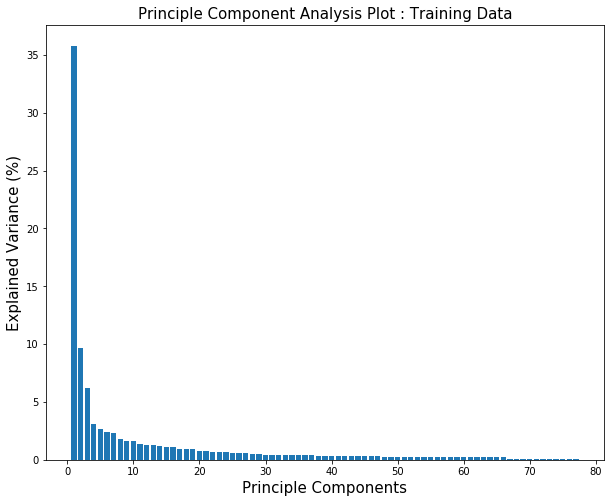

(10907, 77)


In [3]:
#PCA
from sklearn.decomposition import PCA
# Concatenate the training and test datasets into a single datafram
# Choose the number of principle components such that 95% of the variance is retained
pca = PCA(0.95)
X_PCA = pca.fit_transform(X)
varPCA = np.round(pca.explained_variance_ratio_*100, decimals = 1)
# Principal Component Analysis of data
print(varPCA)
plt.figure(figsize=(10,8))
plt.bar(x=range(1,len(varPCA)+1), height = varPCA)
plt.ylabel("Explained Variance (%)", size = 15)
plt.xlabel("Principle Components", size = 15)
plt.title("Principle Component Analysis Plot : Training Data", size = 15)
plt.show()

print(X_PCA.shape)
X_test = X_PCA[4363:]
X = X_PCA[:4363]

In [4]:
#Split data to test-validation set
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, log_loss

def run_model(model, alg_name):
    global X
    global y
    global X_train, X_val, y_train, y_val
    #ros = RandomOverSampler()
    #X_train_res, y_train_res = ros.fit_sample(X_train, y_train)
    y = np.ravel(y)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)
    model.fit(X_train, y_train)
    print("----",alg_name,"----")
    print(model.score(X_val,y_val))
    #Apply cross validation
    scores = cross_validate(model, X, y, cv=3)
    print("Cross-validated scores:", scores["test_score"])
    train_predictions = clf.predict(X_val)
    acc = accuracy_score(y_val, train_predictions)
    print("Accuracy: {:.4%}".format(acc))

#try this  https://www.kaggle.com/coolman/different-classification-techniques-python
#Neural network results highest score
#Model evaluation 
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression



names = ["Nearest Neighbors", "RBF SVM",
         "Decision Tree", "Random Forest", "Neural Net",
         "Naive Bayes", "QDA", "XGBOOST","LogReg"]

classifiers = [
    KNeighborsClassifier(6),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=0.3),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
    XGBClassifier(),
    LogisticRegression()]

for name, clf in zip(names, classifiers):
    run_model(clf, name)
    

---- Nearest Neighbors ----
0.582123758594
Cross-validated scores: [ 0.56623198  0.56769759  0.57339766]


ValueError: y_true and y_pred contain different number of classes 10, 2. Please provide the true labels explicitly through the labels argument. Classes found in y_true: ['1' '10' '2' '3' '4' '5' '6' '7' '8' '9']

Top results:
Neural Net
LogReg
XGBOOST
QDA
Nearest Neighbors
RBF SVM 


In [10]:
#Parameter tuning:

from sklearn.model_selection import GridSearchCV

class gridSearch():
    def __init__(self,model):
        self.model = model
    def grid_get(self,param_grid):
        grid_search = GridSearchCV(self.model,param_grid,scoring='accuracy', cv=3, return_train_score=True)
        grid_search.fit(X,y)
        print(pd.DataFrame(grid_search.cv_results_)[['params','mean_test_score','std_test_score', 'mean_train_score']])
        print('\nBest parameters : {}, best score : {}'.format(grid_search.best_params_,np.sqrt(-grid_search.best_score_)))

In [11]:
#Neural Net

gridSearch(MLPClassifier()).grid_get(
        {'alpha':[0.1,0.3, 0.4, 0.5], 'learning_rate': ['constant','adaptive']})

/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt

                                        params  mean_test_score  \
0  {'alpha': 0.1, 'learning_rate': 'constant'}         0.635572   
1  {'alpha': 0.1, 'learning_rate': 'adaptive'}         0.634426   
2  {'alpha': 0.3, 'learning_rate': 'constant'}         0.647032   
3  {'alpha': 0.3, 'learning_rate': 'adaptive'}         0.648636   
4  {'alpha': 0.4, 'learning_rate': 'constant'}         0.646115   
5  {'alpha': 0.4, 'learning_rate': 'adaptive'}         0.644052   
6  {'alpha': 0.5, 'learning_rate': 'constant'}         0.641531   
7  {'alpha': 0.5, 'learning_rate': 'adaptive'}         0.641989   

   std_test_score  mean_train_score  
0        0.004005          0.842078  
1        0.006705          0.840367  
2        0.003017          0.752694  
3        0.003340          0.749944  
4        0.004801          0.727942  
5        0.002137          0.726793  
6        0.002993          0.710751  
7        0.004007          0.709150  

Best parameters : {'alpha': 0.3, 'learning_rate': 'ad

/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in sqrt
  if sys.path[0] == '':


In [12]:
#LogReg
gridSearch(LogisticRegression()).grid_get(
        {'class_weight': [None, 'balanced'], 'solver': ['newton-cg','saga','lbfgs']})

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linea

                                              params  mean_test_score  \
0      {'class_weight': None, 'solver': 'newton-cg'}         0.632821   
1           {'class_weight': None, 'solver': 'saga'}         0.632821   
2          {'class_weight': None, 'solver': 'lbfgs'}         0.632821   
3  {'class_weight': 'balanced', 'solver': 'newton...         0.545496   
4     {'class_weight': 'balanced', 'solver': 'saga'}         0.508595   
5    {'class_weight': 'balanced', 'solver': 'lbfgs'}         0.545496   

   std_test_score  mean_train_score  
0        0.007314          0.666628  
1        0.007314          0.666628  
2        0.007314          0.666628  
3        0.009360          0.589156  
4        0.005039          0.552496  
5        0.009360          0.589156  

Best parameters : {'class_weight': None, 'solver': 'newton-cg'}, best score : nan


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in sqrt
  if sys.path[0] == '':


In [13]:
#XGBOOST
gridSearch(XGBClassifier()).grid_get(
        { 'max_depth': [3,5], 'subsample':[0.5,0.8,1], 'objective': ['multi:softmax']})

                                              params  mean_test_score  \
0  {'max_depth': 3, 'objective': 'multi:softmax',...         0.614715   
1  {'max_depth': 3, 'objective': 'multi:softmax',...         0.608755   
2  {'max_depth': 3, 'objective': 'multi:softmax',...         0.601650   
3  {'max_depth': 5, 'objective': 'multi:softmax',...         0.614027   
4  {'max_depth': 5, 'objective': 'multi:softmax',...         0.608985   
5  {'max_depth': 5, 'objective': 'multi:softmax',...         0.605776   

   std_test_score  mean_train_score  
0        0.009817          0.861337  
1        0.003409          0.871883  
2        0.003458          0.854230  
3        0.002719          0.991978  
4        0.001427          0.998510  
5        0.000989          0.999198  

Best parameters : {'max_depth': 3, 'objective': 'multi:softmax', 'subsample': 0.5}, best score : nan


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in sqrt
  if sys.path[0] == '':


In [17]:
#QDA uses Bayes, no information --> skip
#Knearest neighbors 
gridSearch(KNeighborsClassifier()).grid_get(
        {'n_neighbors':[20,25,30,35], 'weights':['uniform','distance']})

                                       params  mean_test_score  \
0   {'n_neighbors': 20, 'weights': 'uniform'}         0.581022   
1  {'n_neighbors': 20, 'weights': 'distance'}         0.583085   
2   {'n_neighbors': 25, 'weights': 'uniform'}         0.582168   
3  {'n_neighbors': 25, 'weights': 'distance'}         0.585148   
4   {'n_neighbors': 30, 'weights': 'uniform'}         0.583314   
5  {'n_neighbors': 30, 'weights': 'distance'}         0.584689   
6   {'n_neighbors': 35, 'weights': 'uniform'}         0.582856   
7  {'n_neighbors': 35, 'weights': 'distance'}         0.584460   

   std_test_score  mean_train_score  
0        0.001449          0.618496  
1        0.001000          1.000000  
2        0.003402          0.615859  
3        0.001258          1.000000  
4        0.005188          0.608983  
5        0.004530          1.000000  
6        0.005277          0.605544  
7        0.001605          1.000000  

Best parameters : {'n_neighbors': 25, 'weights': 'distance'}, 

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in sqrt
  if sys.path[0] == '':


In [15]:
gridSearch(SVC()).grid_get({'C':[0.5,1,2], 'kernel': ['poly','rbf', 'sigmoid'], 'class_weight': [None, 'balanced']})

/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default 

/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default 

                                               params  mean_test_score  \
0   {'C': 0.5, 'class_weight': None, 'kernel': 'po...         0.499198   
1   {'C': 0.5, 'class_weight': None, 'kernel': 'rbf'}         0.511804   
2   {'C': 0.5, 'class_weight': None, 'kernel': 'si...         0.499198   
3   {'C': 0.5, 'class_weight': 'balanced', 'kernel...         0.056383   
4   {'C': 0.5, 'class_weight': 'balanced', 'kernel...         0.400871   
5   {'C': 0.5, 'class_weight': 'balanced', 'kernel...         0.369929   
6    {'C': 1, 'class_weight': None, 'kernel': 'poly'}         0.499198   
7     {'C': 1, 'class_weight': None, 'kernel': 'rbf'}         0.565666   
8   {'C': 1, 'class_weight': None, 'kernel': 'sigm...         0.514554   
9   {'C': 1, 'class_weight': 'balanced', 'kernel':...         0.056383   
10  {'C': 1, 'class_weight': 'balanced', 'kernel':...         0.440981   
11  {'C': 1, 'class_weight': 'balanced', 'kernel':...         0.410497   
12   {'C': 2, 'class_weight': None, 'k

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in sqrt
  if sys.path[0] == '':


In [16]:
y_test_pred = model.predict(X_test)
indx = range(y_test_pred.shape[0])
result = pd.DataFrame(index = indx, columns = ["Sample_id","Sample_label"])
result["Sample_id"] = result.index+1
result["Sample_label"] = y_test_pred
result.to_csv("MLPClassifier_MinMaxScaler_PCA_test20.csv", index = False)


NameError: name 'model' is not defined